In [1]:
import csv
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

from tqdm.auto import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

BATCH_SIZE = 128
CROP_SIZE = 224
IMAGE_SHAPE = (224, 224)
PROCESSED_DATASET_PATH_MNETV1_TRAIN = Path("/kaggle/input/dataset/dataset/train/")
PROCESSED_DATASET_PATH_MNETV1_TEST = Path("/kaggle/input/dataset/dataset/test/")
PROCESSED_DATASET_PATH_MNETV1_VAL = Path("/kaggle/input/dataset/dataset/val/")

# PRETRAINED_MODEL = "/kaggle/input/modele2/e2.pth"

print(device)

cuda:0


In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_TRAIN, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

val_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

print(len(train_set), len(val_set), len(test_set), train_set.classes)
print(val_set)


12903 1611 1611 ['cat', 'dog', 'wild']
Dataset ImageFolder
    Number of datapoints: 1611
    Root location: /kaggle/input/dataset/dataset/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


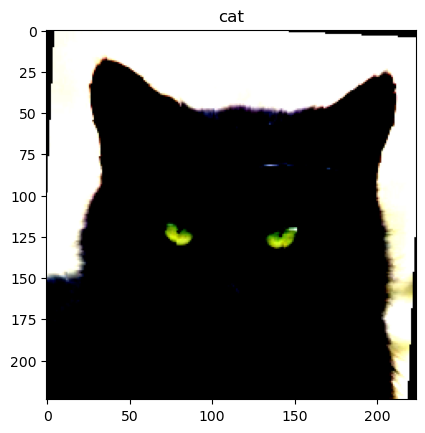

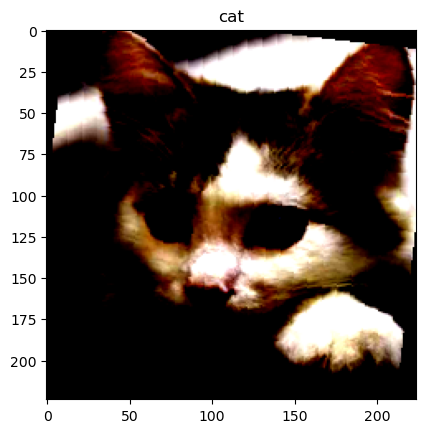

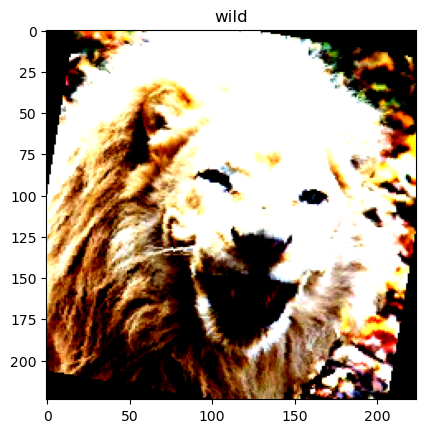

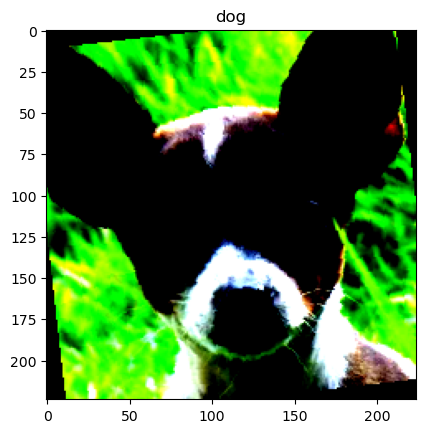

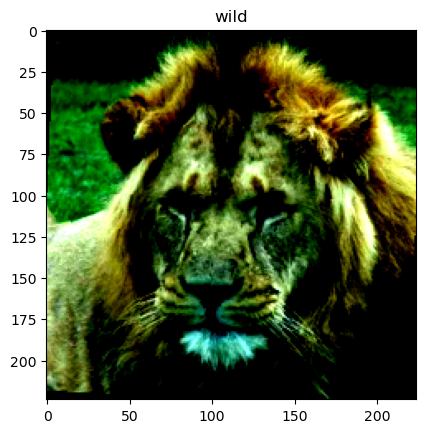

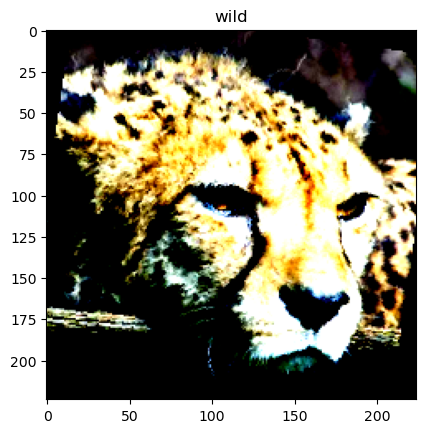

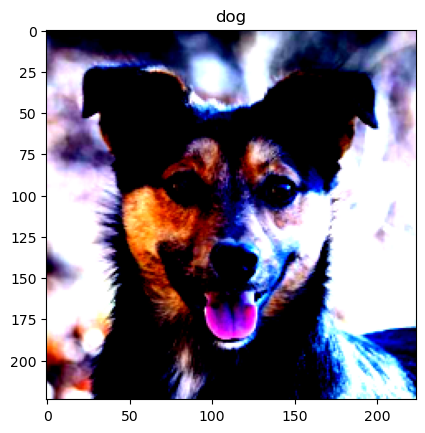

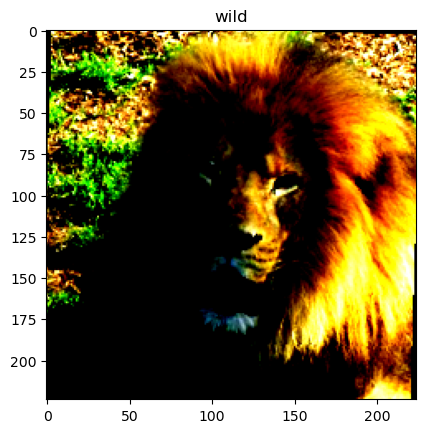

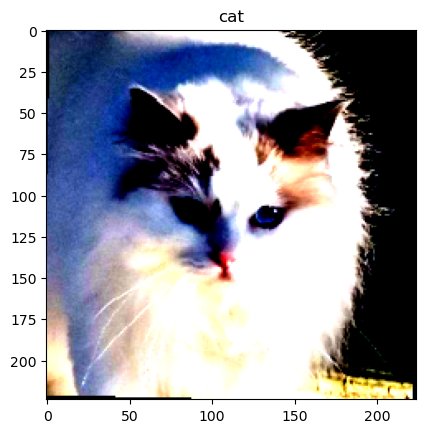

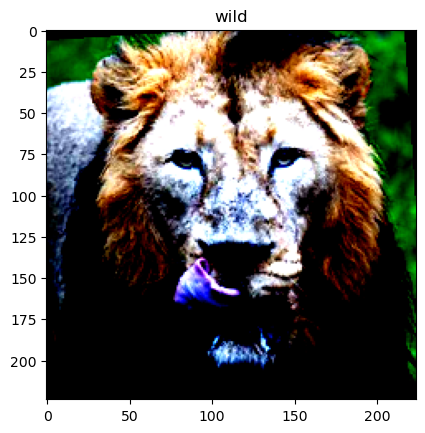

3


In [4]:
train_loader_vis = torch.utils.data.DataLoader(train_set, 15, shuffle=True)

images, labels = next(iter(train_loader_vis))
images, labels = images.numpy() , labels.numpy()

for i in range(10):
    plt.imshow(np.transpose(images[i] , (1,2,0)))
    plt.title(train_set.classes[labels[i]])
    plt.show()
print(len(train_set.classes))

In [5]:
model = torchvision.models.resnet18(num_classes=len(train_set.classes), pretrained=False)
model = model.to(device)
# model.load_state_dict(torch.load(PRETRAINED_MODEL))
model.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
import os
os.makedirs("/kaggle/working/mods")

45

In [9]:
open("/kaggle/working/logs.csv", "a", newline="")
log_file = open("/kaggle/working/logs.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    try:
        if mode == 'train':
            model.train()
        elif mode == 'val':
            model.eval()

        loss = correct = 0
        for feature, target in tqdm(dataloader, desc=mode.title()):
            feature, target = feature.to(device), target.to(device)
            output = model(feature)
            loss = criterion(output, target)

            if mode == 'train':
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            loss += loss.item() * feature.shape[0]
            correct += (output.argmax(1) == target).sum().item()
        loss = loss/len(dataset)
        accuracy = correct/len(dataset)
        return loss, accuracy
    except:
        pass

num_epochs = 30
for epoch in range(1, num_epochs + 1):
    try:
        train_cost, train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer)
        with torch.no_grad():
            test_cost, test_score = loop_fn('val', val_set, val_loader, model, criterion, optimizer)
        print(epoch, float(train_cost), train_score, float(test_cost), test_score)
        csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])
        torch.save(model.state_dict(), f"/kaggle/working/mods/_e{epoch}.pth")
    except:
        pass

Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

1 0.003387203672900796 0.7126249709369914 0.051316019147634506 0.6852886405959032


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/13 [00:00<?, ?it/s]

2 0.0015572606353089213 0.8862280089901573 0.05276720970869064 0.7026691495965239


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Val:   0%|          | 0/13 [00:00<?, ?it/s]

3 0.0009216813487000763 0.9329613268232194 0.02225773222744465 0.851024208566108


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

4 0.0007529252325184643 0.9573742540494459 0.014125477522611618 0.883302296710118


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

5 0.0004839269386138767 0.9696969696969697 0.009192359633743763 0.9397889509621353


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

6 0.0006212387233972549 0.974579555142215 0.017970042303204536 0.8088144009931719


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

8 0.00017186473996844143 0.9826396961946834 0.007363944314420223 0.9633767846058349


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Val:   0%|          | 0/13 [00:00<?, ?it/s]

9 0.0002626356144901365 0.9879872897775711 0.008558419533073902 0.9801365611421478


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Val:   0%|          | 0/13 [00:05<?, ?it/s]

10 0.00041509195580147207 0.9883747965589398 0.010246725752949715 0.9279950341402855


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

11 0.0001429457333870232 0.9899248236844145 5.251973561826162e-05 0.9863438857852266


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

12 0.0003268843865953386 0.9912423467410679 0.006700362544506788 0.9751707014276847


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

13 1.708300806058105e-05 0.9932573820041851 0.007184704765677452 0.9422718808193669


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/13 [00:00<?, ?it/s]

14 0.00040112773422151804 0.9906223358908781 0.0007901503704488277 0.9807572936064556


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/13 [00:05<?, ?it/s]

15 1.079360481526237e-05 0.9929473765790902 2.9744800485786982e-05 0.9900682805710739


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/13 [00:00<?, ?it/s]

16 3.267677311669104e-05 0.9920173603038053 0.003930342383682728 0.9671011793916822


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

17 0.00037263453123159707 0.9910098426722468 0.007332464214414358 0.9677219118559901


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

18 1.774339034454897e-05 0.994729907773386 0.0019060276681557298 0.9875853507138423


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

19 0.00013373121328186244 0.9955049213361233 0.0053496998734772205 0.9565487274984482


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/13 [00:05<?, ?it/s]

20 0.0002640967722982168 0.9942648996357436 0.0021996896248310804 0.9888268156424581


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/13 [00:00<?, ?it/s]

21 0.00031292406492866576 0.9969774471053243 0.002358596306294203 0.9919304779639975


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/13 [00:00<?, ?it/s]

22 0.00043876239215023816 0.9948849104859335 0.0004012059944216162 0.9875853507138423


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

23 3.378315159352496e-05 0.9944199023482911 0.004275911953300238 0.9720670391061452


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

24 8.096652891254053e-05 0.9941098969231962 0.0019938726909458637 0.9851024208566108


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:05<?, ?it/s]

25 1.5450501450686716e-05 0.9972099511741456 0.0009315533097833395 0.994413407821229


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/13 [00:00<?, ?it/s]

26 0.000136759175802581 0.9963574362551345 0.00018983804329764098 0.9894475481067659


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/13 [00:00<?, ?it/s]

27 0.0001560567761771381 0.9963574362551345 7.249097507155966e-06 0.9956548727498448


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92e8d40b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/13 [00:00<?, ?it/s]

28 3.3688613712001825e-06 0.9981399674494303 0.0003471782256383449 0.9950341402855369


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

29 4.3058716983068734e-05 0.9972874525304193 0.005260874982923269 0.957790192427064


Train:   0%|          | 0/101 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:05<?, ?it/s]

30 0.0006360723054967821 0.9944974037045649 0.0030483072623610497 0.9851024208566108
